# <center> Optimización de Portafolio y Modelo Black-Litterman </center>

#### Símbolos Matemáticos usados en este notebook

| Símbolo en Python | Símbolo Matemático | Comment
| -- | -- | --
| rf | $r$ | risk free rate
| lmb | $\lambda$ | risk aversion coefficient
| C | $C$ | Assets covariance matrix
| V | $V$ | Assets variances (diagonal in covariance matrix)
| W | $W$ | Assets weights
| R | $R$ | Assets returns
| mean | $\mu$ | Portfolio historical return
| var | $\sigma$ | Portfolio historical variance
| Pi | $\Pi$ | Portfolio equilibrium excess returns
| tau | $\tau$ | Scaling factor for Black-litterman

In [1]:
%pylab
%matplotlib inline
pylab.rcParams['figure.figsize'] = (10, 6)
import scipy.optimize
from pandas import *

Using matplotlib backend: Qt5Agg
Populating the interactive namespace from numpy and matplotlib


## Creamos algunas helper functions

In [2]:
# Calcula la media de los retornos del portafolio
def port_mean(W, R):
    return sum(R * W)

# Calcula la varianza de los retornos del portafolio
def port_var(W, C):
    return dot(dot(W, C), W)

# Combinacion de las dos funciones anteriores - calculo de la media y la varianza de los retornos
def port_mean_var(W, R, C):
    return port_mean(W, R), port_var(W, C)

In [3]:
# Given risk-free rate, assets returns and covariances, this function calculates
# mean-variance frontier and returns its [x,y] points in two arrays
def solve_frontier(R, C, rf):
    def fitness(W, R, C, r):
        # For given level of return r, find weights which minimizes portfolio variance.
        mean, var = port_mean_var(W, R, C)
        penalty = 100 * abs(
            mean - r)  # Big penalty for not meeting stated portfolio return effectively serves as optimization constraint
        return var + penalty

    frontier_mean= []
    frontier_var = []
    n = len(R)  # Numero de Activos en el Portafolio
    for r in linspace(min(R), max(R), num=20):  # Iterate through the range of returns on Y axis
        W = ones([n]) / n  # start optimization with equal weights
        b_ = [(0, 1) for i in range(n)]  # los pesos de los activos deben estar entre (0,1)
        c_ = ({'type': 'eq', 'fun': lambda W: sum(W) - 1.}) # escribimos la restriccion del problema (suma de pesos -1=0)
        # Realizamos la Optimizacion con REstricciones usando el metodo SLSQP
        optimized = scipy.optimize.minimize(fitness, W, (R, C, r), method='SLSQP', constraints=c_, bounds=b_)
        if not optimized.success:
            raise BaseException(optimized.message)
        # add point to the efficient frontier [x,y] = [optimized.x, r]
        frontier_mean.append(r)
        frontier_var.append(port_var(optimized.x, C))
    return array(frontier_mean), array(frontier_var)

In [4]:
# Given risk-free rate, assets returns and covariances, this function calculates
# weights of tangency portfolio with respect to sharpe ratio maximization
def solve_weights(R, C, rf):
    def fitness(W, R, C, rf):
        mean, var = port_mean_var(W, R, C)  # Calcula la media-varianza del portafolio
        util = (mean - rf) / sqrt(var)  # utility = Sharpe ratio
        return 1 / util  # maximize the utility, minimize its inverse value
    n = len(R)
    W = ones([n]) / n  # start optimization with equal weights
    b_ = [(0., 1.) for i in range(n)]  # weights for boundaries between 0%..100%. No leverage, no shorting
    c_ = ({'type': 'eq', 'fun': lambda W: sum(W) - 1.})  # Sum of weights must be 100%
    optimized = scipy.optimize.minimize(fitness, W, (R, C, rf), method='SLSQP', constraints=c_, bounds=b_)
    if not optimized.success: raise BaseException(optimized.message)
    return optimized.x

In [5]:
class Result:
    def __init__(self, W, tan_mean, tan_var, front_mean, front_var):
        self.W=W
        self.tan_mean=tan_mean
        self.tan_var=tan_var
        self.front_mean=front_mean
        self.front_var=front_var
        
def optimize_frontier(R, C, rf):
    W = solve_weights(R, C, rf)
    tan_mean, tan_var = port_mean_var(W, R, C)  # calcula el portafolio de tangencia
    front_mean, front_var = solve_frontier(R, C, rf)  # calcula la frontera eficiente
    # Weights, Tangency portfolio asset means and variances, Efficient frontier means and variances
    return Result(W, tan_mean, tan_var, front_mean, front_var)

def display_assets(names, R, C, color='black'):
    scatter([C[i, i] ** .5 for i in range(n)], R, marker='x', color=color), grid(True)  # dibuja los activos
    for i in range(n): 
        text(C[i, i] ** .5, R[i], '  %s' % names[i], verticalalignment='center', color=color) # dibuja los labels

def display_frontier(result, label=None, color='black'):
    text(result.tan_var ** .5, result.tan_mean, '   tangent', verticalalignment='center', color=color)
    scatter(result.tan_var ** .5, result.tan_mean, marker='o', color=color), grid(True)
    plot(result.front_var ** .5, result.front_mean, label=label, color=color), grid(True)  # draw efficient frontier

## Cargamos los Precios Históricos 

In [6]:
# Funcion que carga los precios históricos de las acciones de 9 de las principales empresas que conforman
# el SP500, sus retornos, y las capitilizacion de mercado (market cap) para el 2013.

def load_data():
    symbols = ['XOM', 'AAPL', 'MSFT', 'JNJ', 'GE', 'GOOG', 'CVX', 'PG', 'WFC']
    cap = {'XOM': 403.02e9, 'AAPL': 392.90e9, 'MSFT': 283.60e9, 'JNJ': 243.17e9, 'GE': 236.79e9,
           'GOOG': 292.72e9, 'CVX': 231.03e9, 'PG': 214.99e9, 'WFC': 218.79e9}
    n = len(symbols)
    prices_out, caps_out = [], []
    for s in symbols:
        dataframe = pandas.read_csv('data/%s.csv' % s, index_col=None, parse_dates=['date'])
        prices = list(dataframe['close'])[-500:] # Ventana: 500 dias
        prices_out.append(prices)
        caps_out.append(cap[s])
    return symbols, prices_out, caps_out

names, prices, caps = load_data()
n = len(names)

## Estimación de los Retornos y Covarianzas históricas (Estimadores Muestrales)

In [7]:
# Function takes historical stock prices together with market capitalizations and
# calculates weights, historical returns and historical covariances
def assets_historical_returns_and_covariances(prices):
    prices = matrix(prices)  # crear una matriz de numpy para los precios
    # crear la matriz de Retornos Históricos
    rows, cols = prices.shape
    returns = empty([rows, cols - 1])
    for r in range(rows):
        for c in range(cols - 1):
            p0, p1 = prices[r, c], prices[r, c + 1]
            returns[r, c] = (p1 / p0) - 1
    # calcular los retornos
    expreturns = array([])
    for r in range(rows):
        expreturns = append(expreturns, numpy.mean(returns[r]))
    # calcular las covarianzas
    covars = cov(returns)
    expreturns = (1 + expreturns) ** 250 - 1  # Retornos Anualizados
    covars = covars * 250  # Covarianzas Anualizadas
    return expreturns, covars
################################################################################################
W = array(caps) / sum(caps) # calcula los pesos de mercado a partir de las capitalizaciones
R, C = assets_historical_returns_and_covariances(prices)
rf = .015  # Tasa Libre de Riesgo (Risk free rate)

### Los Retornos de los Activos y los Pesos (basados en las Capitalizaciones de Mercado)

In [8]:
display(pandas.DataFrame({'Return': R, 'Weight (based on market cap)': W}, index=names).T)

,XOM,AAPL,MSFT,JNJ,GE,GOOG,CVX,PG,WFC
Return,0.072993,0.129536,0.172047,0.143764,0.140385,0.331958,0.092131,0.112222,0.268935
Weight (based on market cap),0.160119,0.156098,0.112673,0.096611,0.094076,0.116297,0.091787,0.085415,0.086925


#### Las Covarianzas de los Activos 

In [9]:
display(pandas.DataFrame(C, columns=names, index=names))

,XOM,AAPL,MSFT,JNJ,GE,GOOG,CVX,PG,WFC
XOM,0.039015,0.022296,0.027982,0.019595,0.036647,0.026728,0.038245,0.018216,0.042972
AAPL,0.022296,0.091844,0.024599,0.011578,0.027814,0.033249,0.028240,0.011532,0.036756
MSFT,0.027982,0.024599,0.051014,0.016842,0.032649,0.026231,0.030815,0.013724,0.040321
JNJ,0.019595,0.011578,0.016842,0.019456,0.021048,0.015547,0.021005,0.013196,0.026861
GE,0.036647,0.027814,0.032649,0.021048,0.059233,0.031083,0.040677,0.019377,0.053928
GOOG,0.026728,0.033249,0.026231,0.015547,0.031083,0.066899,0.030258,0.015123,0.039019
CVX,0.038245,0.028240,0.030815,0.021005,0.040677,0.030258,0.050857,0.019587,0.048326
PG,0.018216,0.011532,0.013724,0.013196,0.019377,0.015123,0.019587,0.025152,0.022479
WFC,0.042972,0.036756,0.040321,0.026861,0.053928,0.039019,0.048326,0.022479,0.089826


## Mean-Variance Optimization (Markowitz usando los Retornos Históricos)

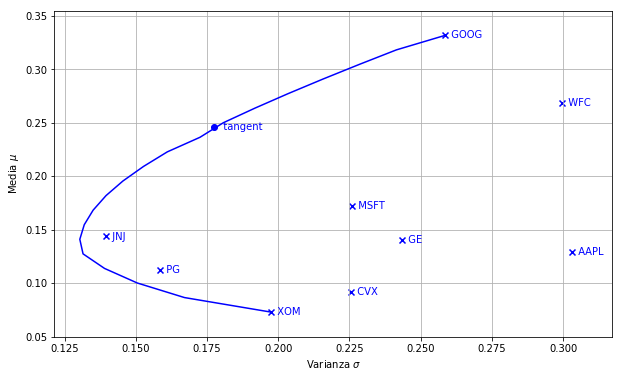

,XOM,AAPL,MSFT,JNJ,GE,GOOG,CVX,PG,WFC
Pesos del Portafolio,0.0,8.389179e-18,8.263130e-18,0.450921,3.595619e-17,0.528356,0.0,0.0,0.020723


In [17]:
res1 = optimize_frontier(R, C, rf)

display_assets(names, R, C, color='blue')
display_frontier(res1, color='blue')
xlabel('Varianza $\sigma$'), ylabel('Media $\mu$'), show()
display(pandas.DataFrame({'Pesos del Portafolio': res1.W}, index=names).T)

## Modelo de Black-litterman

Los Retornos de Mercado de "equilibrio" son aquellos que están implícitos en los pesos de las capitalizaciones de mercado. 

Los Excesos de Retorno de Equilibrio $ \(\pi\)$ se derivan en BL usando: 

$$ \lambda = \frac{r_p - r_f}{\sigma_p^2} $$
$$ \pi=\lambda \cdot \mathbf{\Sigma} \cdot \mathbf{W} $$

In [11]:
# Calculamos los Retornos Historicos y las Covarianzas
mean, var = port_mean_var(W, R, C)

lmb = (mean - rf) / var   # Calculamos la Aversión al riesgo
Pi = dot(dot(lmb, C), W)  # Calculate equilibrium excess returns

### Optimización de Portafolio usando los Retornos de equilibrio (implícitos) 

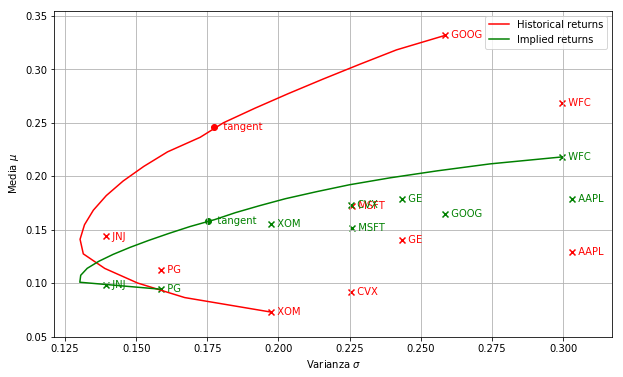

,XOM,AAPL,MSFT,JNJ,GE,GOOG,CVX,PG,WFC
Pesos del Portafolio,0.160429,0.15617,0.112453,0.097424,0.093807,0.116209,0.091813,0.084692,0.087002


In [14]:
res2 = optimize_frontier(Pi+rf, C, rf)
### Graficando la Frontera Eficiente para Markowitz (con Retornos históricos) vs Black Litterman ####
display_assets(names, R, C, color='red')
display_frontier(res1, label='Historical returns', color='red')
display_assets(names, Pi+rf, C, color='green')
display_frontier(res2, label='Implied returns', color='green')
xlabel('Varianza $\sigma$'), ylabel('Media $\mu$'), legend(), show()
display(pandas.DataFrame({'Pesos del Portafolio': res2.W}, index=names).T)

Podemos ver en rojo la Frontera Eficiente basada en los retornos históricos, mientras que en verde se grafica la frontera eficiente para los retornos implícitos o retornos de equilibro. 

Como se puede ver, los Retornos implícitos de Google son solo 16.5% dado el peso que tiene debido a su capitalización de 11.6%, a diferencia de la performance histórica de 33.2% 

### Incorporando las Expectativas/Opiones (Views) del Inversionista en el modelo

La idea detrás del modelo de Black Litterman es incorporar las expectativas/opiniones particulares de los inversionistas sobre los Retornos. En ese tecaso, usamos el forma analítica para calcular los excesos de retornos ajustados por las expectativas. Otra opción es usar inferencia bayesiana. 

Dadas las expectativas y la matriz de enlace (link matrix) $\(\mathbf{Q}\)$ y $\(\mathbf{P}\)$, calculamos los excesos de retornos ajustados por las creencias del inversionista ${\pi}'$ de la siguiente manera:

$$ \tau = 0.025 $$ $$ \Omega = \tau \cdot \mathbf{P} \cdot \mathbf{C} \cdot \mathbf{P}^T $$ $$ {\pi}' = [(\tau \mathbf{C})^{-1} + \mathbf{P}^T \Omega^{-1} \mathbf{P}]^{-1}  \cdot [(\tau \mathbf{C})^{-1} \pi + \mathbf{P}^T \Omega^{-1} \mathbf{Q})] $$ 
donde $\tau$ es un factor de escalamiento, $\Omega$ es la matriz de incertidumbre sobre las expectativas y $\pi'$ es el vector de excesos de retorno ajustado por las expectativas del inversor. 

Notemos que en lugar de especificar explicitamente la matriz P, la derivamos de las formulas anteriores. 

En este caso, tenemos un vector de 9 excesos de retorno, al cual queremos aplicar las creencias del inversionistas. Definimos las creencias del inversionista de la siguiente manera: 

- Microsoft (MSFT) superará a General Electric (GE) en 2%
- Apple (AAPL) será superado por Johnson & Johnson (JNJ) en 2% 

Estas opiniones sobre 2 de los activos, deben ser mapeadas al portafolio de 9 activos. Por lo tanto, las matrices de expectativas (Q) y la matriz de enlace (P) correspondientes son: 

$$ \mathbf{Q}_{1 \times 2} = \begin{pmatrix}0.02 & 0.02\end{pmatrix} $$ $$ \mathbf{P}_{2 \times 9} = \begin{pmatrix}0 & 0 & 1 & 0 &-1 & 0 & 0 & 0 & 0\\ 0 &-1 & 0 & 1 & 0 & 0 & 0 & 0 & 0\end{pmatrix} $$  

donde la primera fila de la matriz de enlace $P$ tiene signo positivo +1 por Microsoft y -1 por General Electric. 

Una vez calculados los Retornos de equilibrio ajustados por las expectativas de los inversionitas, el paso final es realizar la optimización usual al estilo de Markowitz. 

In [18]:
##### Creamos la matriz P y la matriz Q (matriz que contiene las creencias del inversionista sobre
# los Retornos Esperados de los Activos)

In [22]:
def create_views_and_link_matrix(names, views):
    r, c = len(views), len(names)
    Q = [views[i][3] for i in range(r)]  # view matrix
    P = zeros([r, c])
    nameToIndex = dict()
    for i, n in enumerate(names):
        nameToIndex[n] = i
    for i, v in enumerate(views):
        name1, name2 = views[i][0], views[i][2]
        P[i, nameToIndex[name1]] = +1 if views[i][1] == '>' else -1
        P[i, nameToIndex[name2]] = -1 if views[i][1] == '>' else +1
    return array(Q), P

###########################################################
views = [('MSFT', '>', 'GE', 0.02),
         ('AAPL', '<', 'JNJ', 0.02)]
###########################################################


# Llamamos a la funcion creada
Q, P = create_views_and_link_matrix(names, views)
print('Views Matrix (Q)')
display(DataFrame({'Views':Q}))
print('Link Matrix (P)')
display(DataFrame(P))

Views Matrix (Q)


,Views
0,0.02
1,0.02


Link Matrix (P)


,0,1,2,3,4,5,6,7,8
0,0.0,0.0,1.0,0.0,-1.0,0.0,0.0,0.0,0.0
1,0.0,-1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


### Optimización Media-Varianza basada en los Retornos de Equilibrio y las Creencias de los Inversionistas 

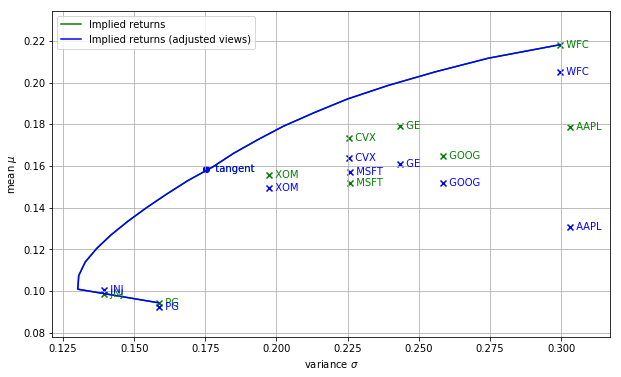

,XOM,AAPL,MSFT,JNJ,GE,GOOG,CVX,PG,WFC
Weight,0.160429,0.15617,0.112453,0.097424,0.093807,0.116209,0.091813,0.084692,0.087002


In [23]:
tau = .025  # factor de escalamiento

# Calcula omega - matriz de incertidumbre de las expectativas
# (matriz de covarianzas para los errores de prediccion del inversionista)
omega = dot(dot(dot(tau, P), C), transpose(P))  # 0.025 * P * C * transpose(P)
# Calculalamos los excesos de retorno incorporando expectativas
sub_a = inv(dot(tau, C))
sub_b = dot(dot(transpose(P), inv(omega)), P)
sub_c = dot(inv(dot(tau, C)), Pi)
sub_d = dot(dot(transpose(P), inv(omega)), Q)
# Matriz de Excesos de Retornos ajustados por las Creencias
Pi_adj = dot(inv(sub_a + sub_b), (sub_c + sub_d))   
##############################################################################
res3 = optimize_frontier(Pi + rf, C, rf)

display_assets(names, Pi+rf, C, color='green')
display_frontier(res2, label='Implied returns', color='green')
display_assets(names, Pi_adj+rf, C, color='blue')
display_frontier(res3, label='Implied returns (adjusted views)', color='blue')
xlabel('variance $\sigma$'), ylabel('mean $\mu$'), legend(), show()
display(pandas.DataFrame({'Weight': res2.W}, index=names).T)

In [25]:
display(pandas.DataFrame({'Weight': res3.W}, index=names).T)

,XOM,AAPL,MSFT,JNJ,GE,GOOG,CVX,PG,WFC
Weight,0.160429,0.15617,0.112453,0.097424,0.093807,0.116209,0.091813,0.084692,0.087002


 El portafolio optimo del inversionista pueder ser considerado como una combinacion de 2 portafolios:
el portafolio de mercado, y la suma ponderada de los "view" portafolios.

En ausencia de creencias particulares sobre los retornos esperados de los activos que conforman el portafolio, el decisión óptima del inversionista será mantener una fracción del portafolio de mercado
w_eq/(1+tau). El tamaño de esta fracción es inversamente proporcional al grado del escepticismo del inversor sobre los retornos de equilibrio estimados (o en otra palabras, en su confianza o escepticismo sobre el CAPM)

## Conclusiones 

Encontramos que ambos modelos se complementan, ya que el modelo de Markowitz es la base de la teoría de selección y el MBL es la parte práctica más precisa para la optimización de portafolios. 

El modelo de BL presenta varias ventajas, tales como: la flexibilidad, la inclusión de las expectativas de mercado, poder
tomar riesgo a un nivel de confianza, tener estabilidad en el tiempo gracias a la incorporació de los retornos de
equilibrio. 